In [ ]:
!pip install tensorflow_privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.5/405.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 50.3 MB/s

In [ ]:
import pandas as pd
import tensorflow.keras.backend as kb
import numpy as np
import tensorflow as tf
import tensorflow_privacy
import keras


df = pd.read_csv('adult_prot.csv')
df_ap = df.loc[(df['103']== 1) & (df['104'] == 1)]
df=df.append([df_ap]*1)
df = df[:-611]
data = df.values[:,:-1]
prot = df.values[:,-1]
feat_size = data.shape[1]-1
print(data.shape, prot.shape)
print(feat_size)

(50000, 104) (50000,)
103


<ipython-input-1-fc5f55809bee>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df.append([df_ap]*1)


In [ ]:
#### Train test split ###
def train_gen():
    train_ix  = np.random.randint(0, len(data), int(0.8*len(data)))
    train_data = data[train_ix, :-1]
    train_prot =  tf.keras.utils.to_categorical(prot[train_ix, np.newaxis], num_classes=num_classes)
    train_labels = tf.keras.utils.to_categorical(data[train_ix, -1], num_classes=num_classes)
    train_labels = np.append(train_labels, train_prot, 1)
    return train_data, train_labels

def test_gen():
    test_ix = np.random.randint(0, len(data), int(0.2*len(data)))
    test_data = data[test_ix, :-1]
    test_prot =  tf.keras.utils.to_categorical(prot[test_ix, np.newaxis], num_classes=num_classes)
    test_labels = tf.keras.utils.to_categorical(data[test_ix, -1], num_classes=num_classes)
    test_labels = np.append(test_labels, test_prot, 1)
    return test_data, test_labels

In [ ]:
# architecture
hidden_size = [50,50]
num_classes = 2
input_size = [int(0.8*len(data)), data.shape[1]-1]
batch_size = 1000
num_epochs = 100
learning_rate = 0.0001
samples_per_network = int(0.8*len(data)/(100))
print(input_size)

l2_norm_clip = 1.5
noise_multiplier = 1.3
num_microbatches = 1

[40000, 103]


In [ ]:
def model_init():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_size[0],
                               activation='relu',
                               input_shape=(feat_size,)),
        tf.keras.layers.Dense(hidden_size[1], activation='relu'),
        tf.keras.layers.Dense(num_classes)
    ])

    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)

    @keras.saving.register_keras_serializable()
    def ce_loss(y_actual, rounded):
        y_true = y_actual[:,:2]
        output = rounded[:,:2]
        # classification loss
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.losses.Reduction.NONE)
        loss1 = loss(y_true, output)
        return loss1

    @keras.saving.register_keras_serializable()
    def EO(y_true, y_pred):
        output = tf.one_hot(kb.argmax(y_pred[:,:2], 1), depth = num_classes)
        prot_data = y_true[:,2:]
        c00 = kb.sum(y_true[:,0] * output[:,1] * prot_data[:,0])/ (kb.sum(prot_data[:,0]*y_true[:,0]))
        c01 = kb.sum(y_true[:,0] * output[:,1] * prot_data[:,1])/ (kb.sum(prot_data[:,1]*y_true[:,0]))
        # FNR
        c10 = kb.sum(y_true[:,1] * output[:,0] * prot_data[:,0])/ (kb.sum(prot_data[:,0]*y_true[:,1]))
        c11 = kb.sum(y_true[:,1] * output[:,0] * prot_data[:,1])/ (kb.sum(prot_data[:,1]*y_true[:,1]))
        loss2 = kb.maximum(kb.abs(c00 - c01), kb.abs(c10 - c11))
        return loss2

    @keras.saving.register_keras_serializable()
    def AccP(y_true, y_pred):
        y_pred = tf.one_hot(kb.argmax(y_pred[:,:2], 1), depth = num_classes)
        prot_data = y_true[:,2:]
        miss = 1.0 - kb.sum(y_pred * y_true[:,:2], 1)
        c0 = kb.sum(miss * prot_data[:,0])/ (kb.sum(prot_data[:,0]))
        c1 = kb.sum(miss * prot_data[:,1])/(kb.sum(prot_data[:,1]))
        loss2 = kb.abs(c0 - c1)
        return loss2

    @keras.saving.register_keras_serializable()
    def DemP(y_true, y_pred):
        y_pred = tf.cast(kb.argmax(y_pred[:,:2], 1), dtype=tf.float32)
        prot_data = y_true[:,2:]
        c0 = kb.sum(y_pred * prot_data[:,0])/ (kb.sum(y_pred))
        c1 = kb.sum(y_pred * prot_data[:,1])/(kb.sum(y_pred))
        loss2 = kb.abs(c0 - c1)
        return loss2

    model.compile(optimizer=optimizer, loss=ce_loss, metrics=['accuracy',EO, AccP, DemP])
    return model

In [ ]:
def train_clients(train_x, train_y, test_x, test_y, wts):
    model = model_init()
    if wts is not None:
        model.set_weights(wts)
    es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.01, patience=200)
    model.fit(train_x, train_y,
              epochs=5,
              validation_data=(test_x, test_y),
              batch_size=batch_size, callbacks = [es])
    return model

In [ ]:
def train_server(g_model, test_x, test_y, client_models):

    layerwise_weights = []
    first_client = True

    for c_model in client_models:
          if first_client:
              for l in c_model.get_weights():
                 layerwise_weights.append(l/5)
              first_client =False
          else:
              for i in range(6):
                  layerwise_weights[i] += c_model.get_weights()[i]/5

    # Update global model
    g_model.set_weights(layerwise_weights)
    # Evaluate global model
    out = g_model.evaluate(test_x, test_y, verbose=0)
    return g_model, out

In [ ]:
import random
train_data, train_labels = train_gen()
test_data, test_labels = test_gen()

global_model = model_init()
num_parts = 5
shuffled_indices = np.random.permutation(train_data.shape[0])

split_data = np.array_split(train_data[shuffled_indices], num_parts, axis=0)
split_label = np.array_split(train_labels[shuffled_indices], num_parts, axis=0)


client_history = []
global_data =[]
wts = None
e =0
for epoch in range(20):
      print("Round {}/{}".format(e+1,20))
      client_models = []
      for client_id in range(5):
          print(" Training for Client[{}/{}]".format(client_id,5))
          client_model = train_clients(split_data[client_id],split_label[client_id], test_data,test_labels,wts)
          client_history.append(client_model.history.history)
          client_models.append(client_model)
      global_model, out = train_server(global_model, test_data, test_labels, client_models)
      global_data.append(out)
      wts = global_model.get_weights()
      print(f'Global Epoch {e + 1}/{num_epochs}, {out}')
      e+=1


Round 1/20
 Training for Client[0/5]
Epoch 1/5
8/8 [==============================] - 2s 62ms/step - loss: 0.8001 - accuracy: 0.2911 - EO: 0.1005 - AccP: 0.1353 - DemP: 0.2760 - val_loss: 0.8010 - val_accuracy: 0.2885 - val_EO: 0.0809 - val_AccP: 0.1202 - val_DemP: 0.2922
Epoch 2/5
8/8 [==============================] - 0s 10ms/step - loss: 0.7992 - accuracy: 0.2915 - EO: 0.0953 - AccP: 0.1345 - DemP: 0.2764 - val_loss: 0.8001 - val_accuracy: 0.2897 - val_EO: 0.0784 - val_AccP: 0.1197 - val_DemP: 0.2928
Epoch 3/5
8/8 [==============================] - 0s 9ms/step - loss: 0.7985 - accuracy: 0.2916 - EO: 0.0937 - AccP: 0.1357 - DemP: 0.2763 - val_loss: 0.7995 - val_accuracy: 0.2904 - val_EO: 0.0795 - val_AccP: 0.1194 - val_DemP: 0.2926
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.7983 - accuracy: 0.2928 - EO: 0.0934 - AccP: 0.1349 - DemP: 0.2770 - val_loss: 0.7995 - val_accuracy: 0.2906 - val_EO: 0.0807 - val_AccP: 0.1197 - val_DemP: 0.2921
Epoch 5/5
8/8 [======

In [ ]:

rounds_list = [client_history[i:i+5] for i in range(0, 100, 5)]
print(len(rounds_list))


print(len(global_data))

20
20


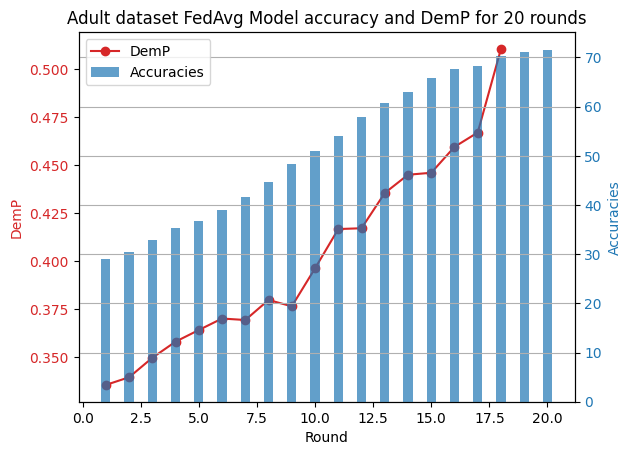

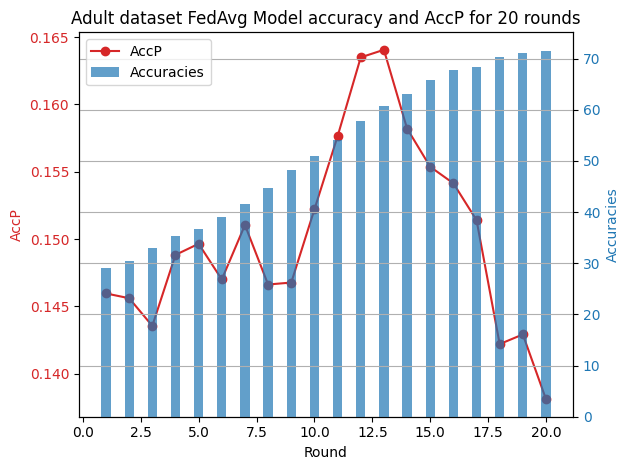

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

accuracies = []
demP = []
AccP = []
rounds = list(range(1, 21))
for round_data in global_data:
    accuracies.append(round_data[1]*100)
    demP.append(round_data[4])
    AccP.append(round_data[3])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Round')
ax1.set_ylabel('DemP', color=color)
ax1.plot(rounds, demP, label='DemP', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for demP
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracies', color=color)
ax2.bar(rounds, accuracies, alpha=0.7, color=color, label='Accuracies', align='center', width=0.4)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlabel("Round")

plt.title("Adult dataset FedAvg Model accuracy and DemP for 20 rounds")
# Adding legend
# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid()



fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Round')
ax1.set_ylabel('AccP', color=color)
ax1.plot(rounds, AccP, label='AccP', marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for demP
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracies', color=color)
ax2.bar(rounds, accuracies, alpha=0.7, color=color, label='Accuracies', align='center', width=0.4)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlabel("Round")

plt.title("Adult dataset FedAvg Model accuracy and AccP for 20 rounds")


# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

